# Random Forest Regression 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

/home/eclipse/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

sns.set_style('darkgrid')

In [4]:
file = '../data/bluebook-for-bulldozers/Train.csv'

In [5]:
df_raw = pd.read_csv(file, parse_dates=['saledate'], low_memory=False)

In [6]:
df_raw.shape

(401125, 53)

Due to computational constriants the model would only run on 10000 samples of the whole data set.

In [7]:
sample_size = 100000 # using only 10000 sample points for this exercise, computational expenses

## A glance through at the properties of the data set.

In [8]:
print('Feature values of the first five samples in the data set :')
df_raw.head()

Feature values of the first five samples in the data set :


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [10]:
print(f'The data set contain {df_raw.shape[0]} samples and {df_raw.shape[1]} features')

The data set contain 401125 samples and 53 features


In [11]:
print(f'Here is a list of the features present in the data set {df_raw.columns}')

Here is a list of the features present in the data set Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
print(f'Description of the data set')
df_raw.describe()

Description of the data set


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,1.427650e+05
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901,3.457955e+03
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469,2.759026e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,3.025000e+03
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,2.483300e+06


## Preparing the data for modelling

In [13]:
df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

The precesseding code splits the data set into the features and target values, where the feature value contains the predictor values and the target holds the target's value (price).

In [14]:
X, y = df_raw.drop('SalePrice', axis=1), df_raw['SalePrice'].copy()
X.shape, y.shape

((401125, 52), (401125,))

### First model without preprocessing the data

In [15]:
rf = RandomForestRegressor(max_samples=sample_size).fit(X, y)

ValueError: could not convert string to float: 'Low'

# All These are my Practice Codes

In [ ]:
# # extracting features fromthe date attribute
# def add_date(df, name):
#     fld = df[name]
#     target = re.sub('[Dd]ate$', '', name)
#     for n in ['Year', 'Month', 'Day']:
#         df[target+n] = getattr(fld.dt, n.lower())
#     df.drop(name, axis=1, inplace=True)
# add_date(df_raw, 'saledate')

In [ ]:
# df_raw

In [ ]:
# df_raw['UsageBand'] = pd.Categorical(df_raw['UsageBand']).codes+1
# df_raw['UsageBand']

In [ ]:
# df_raw.isnull().sum()

In [ ]:
# # Changing object to categorical data types
# for column, content in df_raw.items():
#     if not pd.api.types.is_numeric_dtype(content):
#         df_raw[column] = content.astype('category').cat.as_ordered()

In [ ]:
# # dealing with null values and filling the the values of missing numeric type with their median value       
# for column, content in df_raw.items():
#     if pd.api.types.is_numeric_dtype(content):
#         if pd.isnull(content).sum():                         
#             df_raw[column+'_na'] = pd.isnull(content)
#             df_raw[column] = content.fillna(content.median())

In [ ]:
# df_raw

In [ ]:
# # Dealing with categorical values
# for column, content in df_raw.items():
#     if not pd.api.types.is_numeric_dtype(content):
#         if pd.isnull(content).sum():                                     
#             df_raw[column+'_na'] = pd.isnull(content)
#             df_raw[column] = pd.Categorical(content).codes+1

In [ ]:
# df_raw

In [ ]:
# display(df_raw.iloc[4:, 9::2].tail(20).T)

In [ ]:
# df_raw.info()

In [ ]:
# X, y = df_raw.drop('SalePrice', axis=1), df_raw['SalePrice'].copy()

In [ ]:
# rf = RandomForestRegressor(max_samples=10000, n_jobs=-1).fit(X, y)
# rf.score(X, y)

In [ ]:
#  Splitting the data into train and validation sets

In [ ]:
# test_size = 12000
# train_size = len(X) - test_size

# def split_data(df, size):
#     #splits data in train and validation sets
#     return df[:size].copy(), df[size:].copy()

In [ ]:
# X_train, X_valid = split_data(X, train_size)
# y_train, y_test = split_data(y, train_size)

In [ ]:
# X_train.shape, X_valid.shape, y_train.shape

In [ ]:
# rf= RandomForestRegressor(max_samples=20000, n_jobs=-1).fit(X_train, y_train)
# rf.score(X_train, y_train)

In [ ]:
# X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.30)

In [ ]:
# rf= RandomForestRegressor(max_samples=10000, n_jobs=-1).fit(X_trn, y_trn)
# rf.score(X_trn, y_trn)

# End's Here

In [16]:
df_raw['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
401120   2011-11-02
401121   2011-11-02
401122   2011-11-02
401123   2011-10-25
401124   2011-10-25
Name: saledate, Length: 401125, dtype: datetime64[ns]

In [17]:
# turning the saledate in to unique datetime points
add_datepart(df_raw, 'saledate')

In [18]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [19]:
# dealing with categorical variable
train_cats(df_raw)
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [20]:
df_raw['UsageBand'].cat.set_categories(['High', "Medium", 'Low'], inplace=True)

In [21]:
df_raw['UsageBand'].cat.codes

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

In [22]:
print(f'After preprocessing out data set, it now contains {df_raw.shape[0]} samples and {df_raw.shape[1]} features')

After preprocessing out data set, it now contains 401125 samples and 65 features


In [23]:
# saving the file to feather-format
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/df_raw1')

In [24]:
df_raw = pd.read_feather('tmp/df_raw1')

In [25]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,9.259131,1840702,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401121,6333337,9.305651,1830472,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401122,6333338,9.350102,1887659,21439,149,1.0,2005,NaN,NaN,35NX2,...,2,2,306,False,False,False,False,False,False,1320192000
401123,6333341,9.104980,1903570,21435,149,2.0,2005,NaN,NaN,30NX,...,25,1,298,False,False,False,False,False,False,1319500800


In [26]:
df, y, _ = proc_df(df_raw, 'SalePrice', subset=sample_size)
df.shape

(100000, 66)

# Building a second model

In [27]:
# Making a model
rf = RandomForestRegressor().fit(df, y)
print(f'Train score(R^2) : {round(rf.score(df, y), 3)}')

Train score(R^2) : 0.985


### splitting into train and validation sets

In [42]:
# splitting the data
n_size = 12000
trn_size = len(df) - n_size

def split(df, n):
    return df[:n].copy(), df[n:].copy()

X_train, X_valid = split(df, trn_size)
y_train, y_valid = split(y, trn_size)

X_train.shape, X_valid.shape, y_train.shape


((88000, 66), (12000, 66), (88000,))

In [29]:
def rmse(predictions, actuals):
    '''returns the root mean squared error
    of the true value and predicted values
    
    --------------
    predictions : predicted values .i.e model.predict(X)
    actuals : actual value of the true target variable (y)
    '''
    return np.sqrt(mean_squared_error(predictions, actuals))

def print_score(model):
    '''returns a set of scores from the model. If the oob_score hyperparameter is given it appends it's score 
    '''
    res = [rmse(model.predict(X_train), y_train), rmse(model.predict(X_valid), y_valid), 
           model.score(X_train, y_train), model.score(X_valid, y_valid)]
    if hasattr(model, 'oob_score_'):
        res.append(model.oob_score_)
        print(f'OOB score of the model : {res[4]}')
    print(f'RMSE of the train set : {res[0]}')
    print(f'RMSE of the validation set : {res[1]}')
    print(f'R^2 score of the train set : {res[2]}')
    print(f'R^2 score of the validation set : {res[3]}')

In [30]:
rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.0865201582771845
RMSE of the validation set : 0.26213073735832454
R^2 score of the train set : 0.9843836094328581
R^2 score of the validation set : 0.8683700641426433


From this model we get a RMSE score for the validation set which would place us in the top 29% in the kaggle public leader board. But the R^2 score of the validation is much lower than that of the training set, which would suggest that the data is overfitting.

#  Building a single tree

In [31]:
rf = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.5374297554372752
RMSE of the validation set : 0.5998116565399805
R^2 score of the train set : 0.3974550267613722
R^2 score of the validation set : 0.3107947543949694


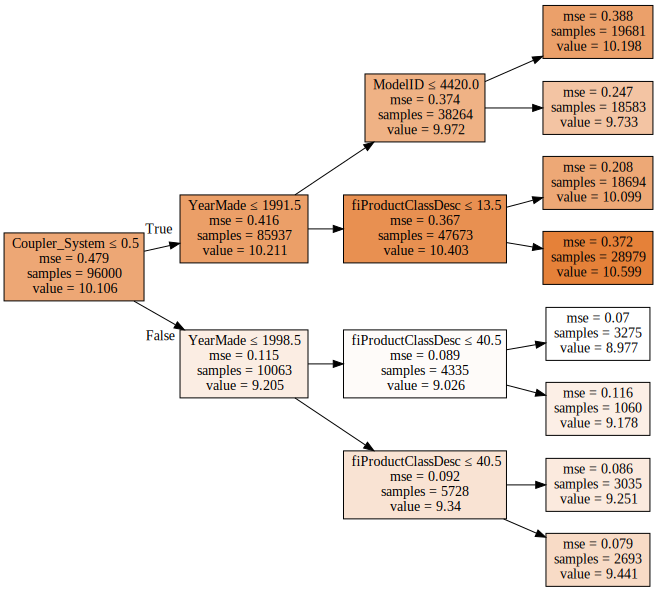

In [32]:
draw_tree(rf.estimators_[0], df, precision=3, ratio=0.9)

In [33]:
# Building a very deep single tree
rf = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 8.484312441289354e-17
RMSE of the validation set : 0.3937192565322008
R^2 score of the train set : 1.0
R^2 score of the validation set : 0.7030440140635894


##  Hyperparameter Turning

### Using bagging method to build a better model

In [34]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.10276523035677465
RMSE of the validation set : 0.2806530868782753
R^2 score of the train set : 0.9779687848411432
R^2 score of the validation set : 0.8491107089357598


In [35]:
preds = np.stack([t.predict(X_valid) for t in rf.estimators_])
preds[:, 0], preds[:, 0].mean(), y_valid[0]

(array([11.35041, 11.35041, 11.15625, 11.15625, 11.51293, 11.01863, 11.28978, 11.81303, 11.44035, 11.4721 ]),
 11.356013893479552,
 11.320553572322773)

Increasing the number of tree to see if the model would improve

In [36]:
rf = RandomForestRegressor(n_estimators=20).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.09418330612782132
RMSE of the validation set : 0.2701593000349475
R^2 score of the train set : 0.9814947944006084
R^2 score of the validation set : 0.8601834388805935


In [37]:
rf = RandomForestRegressor(n_estimators=30).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.09071993636806647
RMSE of the validation set : 0.2678372964383188
R^2 score of the train set : 0.9828307420476473
R^2 score of the validation set : 0.8625765407589985


In [38]:
rf = RandomForestRegressor(n_estimators=40).fit(X_train, y_train)
print_score(rf)

RMSE of the train set : 0.08937117144591034
RMSE of the validation set : 0.2645147923950682
R^2 score of the train set : 0.9833374696758302
R^2 score of the validation set : 0.8659648516518355


## Using the oob_score_

In [39]:
rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1).fit(X_train, y_train)
print_score(rf)

OOB score of the model : 0.8814166072432864
RMSE of the train set : 0.08900854440121414
RMSE of the validation set : 0.26738339991712373
R^2 score of the train set : 0.9834724130950168
R^2 score of the validation set : 0.8630419216259282


### Setting the minimun number of leaf nodes

In [40]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, oob_score=True, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

OOB score of the model : 0.881868087956587
RMSE of the train set : 0.12840167953311923
RMSE of the validation set : 0.26258560508052803
R^2 score of the train set : 0.9656056219430861
R^2 score of the validation set : 0.8679128407076964


### setting the max number of features

In [41]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3,
                           oob_score=True, max_features=0.5, n_jobs=-1)
rf.fit(X_train, y_train)
print_score(rf)

OOB score of the model : 0.8871596103512808
RMSE of the train set : 0.1320377826462345
RMSE of the validation set : 0.2551933546007444
R^2 score of the train set : 0.9636300673662616
R^2 score of the validation set : 0.8752451342641315
